In [2]:
import pandas as pd
import numpy as np
import json
from pprint import pprint
import boto3
from pandas.io.json import json_normalize
import pandas as pd

import nltk
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
bucket = 'ads.hw4.bucket.knagori'
folder = 'data'


cols = ['review_id', 'user_id', 'business_id','text','sentiment']
lst = []


In [4]:
# get the region (pay attention to the region of your S3, SageMaker ... keep them in same region where possible)
region = boto3.Session().region_name


In [5]:
# create the s3 client
s3 = boto3.client('s3')
bucket = 'ads.hw4.bucket.knagori'
folder = 'data'
obj = s3.get_object(Bucket=bucket, Key=f'data/5k_lines.json')
file_content = obj['Body'].read().decode('utf-8') 

#print (file_content)

[5, 1, 2, 5, 1, 5, 5, 4, 2, 5]
5    823
4    504
1    278
3    268
2    151
Name: StarRating, dtype: int64
5    40.662055
4    24.901186
1    13.735178
3    13.241107
2     7.460474
Name: StarRating, dtype: float64


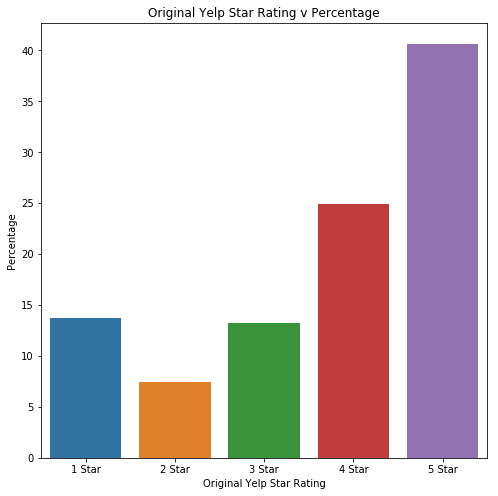

In [27]:
cols2 = ['review_id', 'stars']
yelp_data = []
for kv in file_content.split("\n"):
    json_content = json.loads(kv)
    review_id = json_content['review_id']
    user_id = json_content['user_id']
    business_id = json_content['business_id']
    stars = json_content['stars']
    sentiment_text = json_content['text']
    yelp_data.append(stars) 
pprint(yelp_data[:10], width=100)
Yelp_Star = pd.DataFrame(yelp_data, columns=['StarRating'])
Yelp_Star.head(10)
print(Yelp_Star.StarRating.value_counts())

print(Yelp_Star.StarRating.value_counts(normalize=True) * 100)

fig, ax = plt.subplots(figsize=(8, 8))

counts = Yelp_Star.StarRating.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])
ax.set_ylabel("Percentage")
ax.set_xlabel("Original Yelp Star Rating")
ax.set_title("Original Yelp Star Rating v Percentage")


plt.show()

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for kv in file_content.split("\n"):
    json_content = json.loads(kv)
    review_id = json_content['review_id']
    user_id = json_content['user_id']
    business_id = json_content['business_id']
    sentiment_text = json_content['text']
    pol_score = sia.polarity_scores(sentiment_text)
    pol_score['sentiment_text'] = sentiment_text
    results.append(pol_score)

pprint(results[:10], width=100)

[{'compound': 0.9875,
  'neg': 0.0,
  'neu': 0.575,
  'pos': 0.425,
  'sentiment_text': 'I love this place! My fiance And I go here atleast once a week. The portions '
                    'are huge! Food is amazing. I love their carne asada. They have great lunch '
                    'specials... Leticia is super nice and cares about what you think of her '
                    'restaurant. You have to try their cheese enchiladas too the sauce is '
                    'different And amazing!!!'},
 {'compound': -0.1779,
  'neg': 0.148,
  'neu': 0.724,
  'pos': 0.128,
  'sentiment_text': 'Terrible. Dry corn bread. Rib tips were all fat and mushy and had no flavor. '
                    'If you want bbq in this neighborhood go to john mulls roadkill grill. Trust '
                    'me.'},
 {'compound': 0.6576,
  'neg': 0.099,
  'neu': 0.796,
  'pos': 0.106,
  'sentiment_text': "Back in 2005-2007 this place was my FAVORITE thai place EVER. I'd go here "
                    'ALLLLL the t

In [8]:
#This is used to simply organize the results from the previous query and make it more readable.
df = pd.DataFrame.from_records(results)
df.head(20)
# The results below show compound, negative, neutral, and positive. Negative, neutral, and positive add up to 1

,compound,neg,neu,pos,sentiment_text
0,0.9875,0.000,0.575,0.425,I love this place! My fiance And I go here atl...
1,-0.1779,0.148,0.724,0.128,Terrible. Dry corn bread. Rib tips were all fa...
2,0.6576,0.099,0.796,0.106,Back in 2005-2007 this place was my FAVORITE t...
3,0.9604,0.000,0.543,0.457,Delicious healthy food. The steak is amazing. ...
4,-0.9279,0.238,0.690,0.072,This place sucks. The customer service is horr...
5,0.9705,0.038,0.781,0.180,"If you like Thai food, you have to try the ori..."
6,0.9425,0.118,0.707,0.175,AMAZING!!!\n\n I was referred here by a friend...
7,0.9660,0.000,0.725,0.275,Ribs = amazing\n2 hour wait time= not so amazi...
8,0.7594,0.126,0.732,0.142,"Food is pretty good, not gonna lie. BUT you ha..."
9,0.2944,0.067,0.798,0.135,I have been an Emerald Club member for a numbe...


In [9]:
#Since the 3 columns add up to 1 they will be used generate a star classification system based on the amount negativity, neutrality, or positive in each review
# 5 star = 0.0 negative and greater than average pos
# 4 star = 
# 3 star = neutral is highest
# 2 star = 
# 1 star = 0.0 pos and greater than average pos
# Neutral
#df[['pos']].mean() #0.223
#df[['pos']].max() #0.556
#df[['pos']].min() #0.0


print("Mean pos:       ", df.pos.mean())
print("Minimum pos:    ", df.pos.min())
print("Maximum pos:    ", df.pos.max())

print("Mean neu:       ", df.neu.mean())
print("Minimum neu:    ", df.neu.min())
print("Maximum neu:    ", df.neu.max())

print("Mean neg:       ", df.neg.mean())
print("Minimum neg:    ", df.neg.min())
print("Maximum neg:    ", df.neg.max())

#print("Mean compound:       ", df.compound.mean())
#print("Minimum compound:    ", df.compound.min())
#print("Maximum compound:    ", df.compound.max())

Mean pos:        0.20172826086956527
Minimum pos:     0.0
Maximum pos:     0.642
Mean neu:        0.7529318181818179
Minimum neu:     0.0
Maximum neu:     1.0
Mean neg:        0.0448458498023716
Minimum neg:     0.0
Maximum neg:     0.483


In [21]:
df['label'] = 3

# First labeling 4 and 5 star reviews. 
#5 star review should have positive reviews sentiment higher than average but no negative sentiment.
#4 review should have positive reviews sentiment higher than average but negative sentiment included.
#df.loc[(df['pos'] > df['neu']), 'label'] = 4
df.loc[(df['pos'] > df['neu']) | (df['neg'] == 0.000), 'label'] = 5
df.loc[(df['pos'] > df['neu']), 'label'] = 4

# Second labeling 1 and 2 star reviews. 
#1 star review should have negative reviews sentiment higher than average but no positive sentiment.
#2 review should have negative reviews sentiment higher than average but positive sentiment included.
df.loc[df['neu'] > np.mean(df.neu), 'label'] = 3
df.loc[(df['neg'] > np.mean(df.neg)), 'label'] = 2
df.loc[(df['pos'] == 0.000), 'label'] = 1

# Third labeling 3 star reviews. 
# 3 star review should have neutral sentiment higher than average.
# Reason 3 is last is there are occassions where neg or pos are zero or to an extreme but neutral sentiment is the highest.

df.head(20)

,compound,neg,neu,pos,sentiment_text,label
0,0.9875,0.000,0.575,0.425,I love this place! My fiance And I go here atl...,5
1,-0.1779,0.148,0.724,0.128,Terrible. Dry corn bread. Rib tips were all fa...,2
2,0.6576,0.099,0.796,0.106,Back in 2005-2007 this place was my FAVORITE t...,2
3,0.9604,0.000,0.543,0.457,Delicious healthy food. The steak is amazing. ...,5
4,-0.9279,0.238,0.690,0.072,This place sucks. The customer service is horr...,2
5,0.9705,0.038,0.781,0.180,"If you like Thai food, you have to try the ori...",3
6,0.9425,0.118,0.707,0.175,AMAZING!!!\n\n I was referred here by a friend...,2
7,0.9660,0.000,0.725,0.275,Ribs = amazing\n2 hour wait time= not so amazi...,5
8,0.7594,0.126,0.732,0.142,"Food is pretty good, not gonna lie. BUT you ha...",2
9,0.2944,0.067,0.798,0.135,I have been an Emerald Club member for a numbe...,2


In [22]:
#The purpose of this section simply to look at 
print("Positive Reviews:\n")
pprint(list(df[df['label'] > 3].sentiment_text)[:1], width=200)
# Using less than 3 here considering 4 and 5 star ratings as being generally positive and 1 and 2 star rating as being generally negative
print("Negative Reviews:")
pprint(list(df[df['label'] < 3].sentiment_text)[:1], width=200)

Positive Reviews:

['I love this place! My fiance And I go here atleast once a week. The portions are huge! Food is amazing. I love their carne asada. They have great lunch specials... Leticia is super nice and cares '
 'about what you think of her restaurant. You have to try their cheese enchiladas too the sauce is different And amazing!!!']
Negative Reviews:
['Terrible. Dry corn bread. Rib tips were all fat and mushy and had no flavor. If you want bbq in this neighborhood go to john mulls roadkill grill. Trust me.']


In [23]:
#The purpose of this section simply to look at 
print("5 Star Reviews:\n")
pprint(list(df[df['label'] == 5].sentiment_text)[:1], width=200)
print("4 Star Reviews:\n")
pprint(list(df[df['label'] == 4].sentiment_text)[:1], width=200)
print("3 Star Reviews:\n")
pprint(list(df[df['label'] == 3].sentiment_text)[:1], width=200)
print("2 Star Reviews:\n")
pprint(list(df[df['label'] == 2].sentiment_text)[:1], width=200)
print("1 Star Reviews:\n")
pprint(list(df[df['label'] == 1].sentiment_text)[:1], width=200)


5 Star Reviews:

['I love this place! My fiance And I go here atleast once a week. The portions are huge! Food is amazing. I love their carne asada. They have great lunch specials... Leticia is super nice and cares '
 'about what you think of her restaurant. You have to try their cheese enchiladas too the sauce is different And amazing!!!']
4 Star Reviews:

['Delicious, friendly staff, cool atmosphere, all around great experience! They have a pretty great selection of crepes and omelettes, among other things. I enjoyed the Cherry Omelette (cherry '
 'tomatoes, swiss cheese, potato slices, and bacon) which was pretty big and cooked perfectly! Nice side salad and bread as well. Coffee was great and our server was warm and polite. Would '
 'recommend!']
3 Star Reviews:

['If you like Thai food, you have to try the original thai bbq. Their pad se ew is to DIE for. Their thai egg rolls are delicious. Basil beef will not let you down (its not on the menu anymore, you '
 'have to ask for it!)

In [24]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

3    823
2    717
5    373
1     76
4     35
Name: label, dtype: int64
3    40.662055
2    35.424901
5    18.428854
1     3.754941
4     1.729249
Name: label, dtype: float64


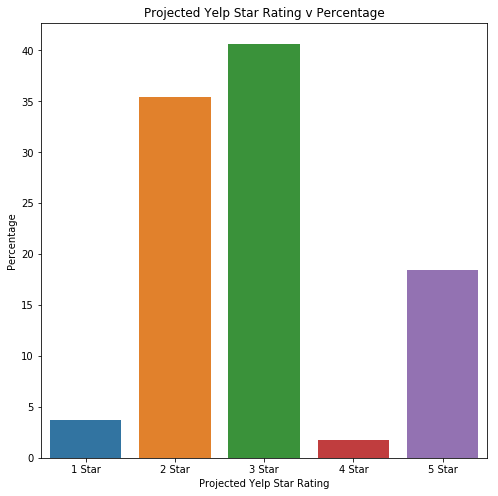

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])
ax.set_ylabel("Percentage")
ax.set_xlabel("Projected Yelp Star Rating")
ax.set_title("Projected Yelp Star Rating v Percentage")
plt.show()